# 5. Investigating Survival/Recurrace
This notebook is for exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [1]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataset import TNBC2
import os
import numpy as np
from numba import jit
from tqdm import tqdm
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})


In [2]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pat = df_pat.replace(-0.99, np.NaN)

df_pat["TILs"] = df_pat["TILs helsnitt"]
df_pat["nodes"] = df_pat["Positive nodes"]
df_pat["age"] = df_pat["Age at diagnosis"]

df_pat["treated"] = df_pat["Chemo (schema)"].apply(lambda x: int(x != "None"))
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"]
df_pat["dead"] = df_pat["Dead yes 1 no 0"]
df_pat["OS"] = df_pat["OS yes 1 no 0"]
df_pat["IDFS"] = df_pat["IDFS yes 1 no 0"]
df_pat["DRFI"] = df_pat["DRFI Breast cancer spec"]

df_pat["distant_relapse"] = (df_pat["Months_surgery_distant_relapse"] > 0).apply(int)
df_pat["local_relapse"] = df_pat["relapse"] - df_pat["distant_relapse"]

df_pat["rapid_dist_relapse"] = df_pat["Months_surgery_distant_relapse"] < 24

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

@jit(nopython=False)
def ripleys_k(locations, t=50):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    n = locations.shape[0]
    within_t = 0
    z = np.array([[complex(x, y) for x, y in locations]])
    distances = abs(z.T-z)
    within_t = np.sum(distances[0] < t)
        
    return np.sqrt(within_t / n)

def _patient_id(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    
def _image_path(patient_id):
    block, letters, numbers = _tma_id(patient_id)
    paths = []
    dataset = TNBC2()
    for let, num in zip(letters, numbers):
        for file in os.listdir(dataset.image_dir):
            b, n, l = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", file)[0]
            if int(b) == block and int(n) == num and l == let:
                paths.append(dataset.image_dir / file)
    return paths

def display(tma_id):
    plt.figure(figsize=(20,10))
    for n, path in enumerate(_image_path(tma_id), 1):
        plt.subplot(1,2,n)
        plt.imshow(imread(path))
        
def correlation(df, features):
    corrmat = df[features].corr(method='spearman')
    plt.figure(figsize=(8,8))
    sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)
    
def corrfunc(df, **kws):
    x, y = zip(*df.dropna().values)
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.set_title(f"r = {r:.2f}, p = {p:.2E}")
    

## Split TILs into stromal and intratumoral

<img src="../docs/stromal_intratumoral_tils.png" width="500" align="left"/>


In [4]:
from scipy.spatial import distance

@jit(nopython=False)
def tumor_stroma_tils(immune_loc, tumor_loc, r=50, factor=1.0):
    """ Estimates which immune cells are Stromal TILs and which
        are Intratumoral."""
    tumor_loc = np.array([list(coord) for coord in tumor_loc], np.float32)
    immune_loc = np.array([list(coord) for coord in immune_loc], np.float32)
    
    tumor_dist = distance.cdist(tumor_loc,immune_loc)
    immune_dist = distance.cdist(immune_loc,immune_loc)
    
    tumor_within_r = tumor_dist < r
    immune_within_r = immune_dist < r
    
    n_tumor_within = tumor_within_r.sum(axis=0)
    n_immune_within = immune_within_r.sum(axis=0)
    
    tumor_tils = n_tumor_within > n_immune_within*factor
    stroma_tils = n_tumor_within*factor < n_immune_within

    return immune_loc[tumor_tils], immune_loc[stroma_tils]

size = 8
def display_cells(df):
    tnbc = TNBC2()
    for n, row in df.iterrows():
        immune_loc = row["immune_loc"]
        tumor_loc = row["tumor_loc"]
        imid = row["image_id"]
        img = tnbc.load_image(imid)

        tumor_tils, stroma_tils = tumor_stroma_tils(immune_loc, tumor_loc)

        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
        ax = plt.gca()
        ax.invert_yaxis()
        args = lambda locs: list(zip(*locs))[::-1]
        plt.title(f"Tumor cells: {len(tumor_loc)}\n TILs: {len(immune_loc)}")
        plt.scatter(*args(tumor_loc), label="Tumor cells", s=size)
        #plt.scatter(*args(immune_loc), label="TILs", s=size)
        plt.scatter(*args(tumor_tils), label="Intratumoral TILs", s=size)
        plt.scatter(*args(stroma_tils), label="Stromal TILs", s=size)
        plt.legend()
    
def pat_id_wsi(image_id):
    try:
        return int(re.findall(r"\d+", image_id)[0])
    except:
        return np.NaN


In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass
    #print(df_wsi.sort_values("TMAid"))
    #print(df_wsi["TMAid"].value_counts())

In [6]:
def box(point):
    y, x = point
    s = 15
    x2, x1 = (int(x+s), int(x-s))
    y2, y1 = (int(y+s), int(y-s))
    return slice(y1, y2, None), slice(x1,x2,None)


In [7]:
from joblib import Memory

memory = Memory('./cache/')

def make_dataframe(path, r1=50, r2=100, factor=1.5):
    df_pred = pd.read_feather(path)
    df_pred = df_pred[df_pred["tumor_loc"].apply(lambda x: len(x) > 0)]
    df_pred = df_pred[df_pred["immune_loc"].apply(lambda x: len(x) > 0)]

    df_pred["tumor_tils_loc"], df_pred["stroma_tils_loc"] = zip(*[
        tumor_stroma_tils(im, tum, r2, factor) for im, tum in zip(df_pred["immune_loc"], df_pred["tumor_loc"])
    ])
    

    df_pred["stroma_tils"] = [len(loc) for loc in tqdm(df_pred["stroma_tils_loc"])]
    df_pred["tumor_tils"] = [len(loc) for loc in tqdm(df_pred["tumor_tils_loc"])]

    df_pred["immune_cluster1"] = [ripleys_k(loc, r1) for loc in tqdm(df_pred["immune_loc"])]
    df_pred["immune_cluster2"] = [ripleys_k(loc, r1+60) for loc in tqdm(df_pred["immune_loc"])]
    df_pred["immune_cluster3"] = [ripleys_k(loc, r1+80) for loc in tqdm(df_pred["immune_loc"])]
    df_pred["immune_cluster4"] = [ripleys_k(loc, r1+120) for loc in tqdm(df_pred["immune_loc"])]
    
    df_pred["tumor_cluster"] = [ripleys_k(loc, r1) for loc in tqdm(df_pred["tumor_loc"])]
    
    #df_pred["TMAid"] = df_pred["image_id"].apply(_patient_id)
    df_pred["TMAid"] = df_pred["image_id"].apply(pat_id_wsi)
    df_pred = df_pred[df_pred["image_id"] != "TNBC_Block_3_block_1_314054_8_M_HE"]

    df_pred_merged = df_pred.groupby("TMAid").mean().reset_index()
    df_all = pd.merge(df_pat, df_pred_merged, how='inner', on=["TMAid"])

    return df_all

In [8]:
def plot_compare(ylabels, xlabels, df, **kwargs):
    plt.figure(figsize=(5*len(ylabels),4))
    features = [[x, y] for x in xlabels for y in ylabels]
    for n, feat in enumerate(features, 1):
        plt.subplot(1,len(ylabels),n)
        sns.scatterplot(data=df, x=feat[0], y=feat[1], **kwargs)
        corrfunc(df[feat])

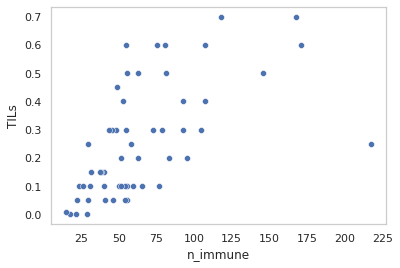

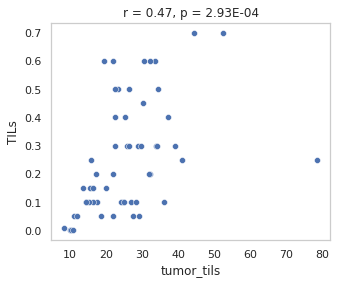

In [14]:
sns.scatterplot(data=df_all, x="n_immune", y="TILs")
plot_compare(["TILs"], ["tumor_tils"], df_all)

In [9]:
df_treated["st/ni"] =  df_treated["stroma_tils"] / df_treated["n_immune"]
sns.scatterplot(data=df_treated, x="st/ni", y="tumor_tils", hue="distant_relapse")


NameError: name 'df_treated' is not defined

In [128]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

def logit(x_train, y_train, x_val, y_val):
    model = sm.Logit(y_train, x_train).fit(disp=False)
    return model.predict(x_val)

def cross_validation(y, X, model = logit):
    undersample = RandomUnderSampler(sampling_strategy=1.0, random_state=1)
    oversample = SMOTE(sampling_strategy=0.4, random_state=1)

    steps = [('o', oversample), ('u', undersample)]
    pipeline = Pipeline(steps=steps)

    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    true, pred, = ([], [])
    summaries = []
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        for train_idx, val_idx in cv_inner.split(X_train_val, y_train_val):
            x_train, x_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            #x_train, y_train = pipeline.fit_resample(x_train, y_train)
            
            y_pred = model(x_train, y_train, x_val, y_val)
            true.extend(list(y_val))
            pred.extend(list(y_pred))
            #summaries.append(_results_to_pandas(model.summary()))
                

    #if results:
    #    print(pd.concat(summaries).groupby(level=0).mean())
        
    return true, pred

In [10]:
#df_all = make_dataframe('./wsi_unet_quip_10000_0.05_5_1.0_800.feather', 100, 100)
#df_all = make_dataframe('./wsi_unet_quip_10000_0.05_5_1.0_800.feather')
df_all = make_dataframe('./wsi_quip2_0.2_5_1.0_1600.feather')

<ipython-input-4-98d41abe1e54>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tumor_stroma_tils" failed type inference due to: non-precise type array(pyobject, 1d, C)
During: typing of argument at <ipython-input-4-98d41abe1e54> (7)

File "<ipython-input-4-98d41abe1e54>", line 7:
def tumor_stroma_tils(immune_loc, tumor_loc, r=50, factor=1.0):
    <source elided>
        are Intratumoral."""
    tumor_loc = np.array([list(coord) for coord in tumor_loc], np.float32)
    ^

  @jit(nopython=False)
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "tumor_stroma_tils" was compiled in object mode without forceobj=True.

File "<ipython-input-4-98d41abe1e54>", line 4:
@jit(nopython=False)
def tumor_stroma_tils(immune_loc, tumor_loc, r=50, factor=1.0):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packag

In [196]:
from itertools import combinations, chain, product, permutations
from tqdm import tqdm
from patsy import dmatrices
group = ["distant_relapse"]

features = [
    #"TILs",
    #"immune_cluster1",
    #"immune_cluster2",
    #"immune_cluster3",
    #"immune_cluster4",
    #"tumor_cluster",
    #"n_immune",
    #"n_tumor",
    #"stroma_tils",
    #"tumor_tils",
    #"tumor_area",
    #"immune_area",
    "age",
    #"nodes",
]

pd.options.mode.chained_assignment = None

def try_interactions(data, features, group):
    d = []
    for f in tqdm(list(chain(*[combinations(features, i) for i in [1]]))):
        f = list(f)
        formulas = [
             f"{group} ~ {':'.join(f)}",
             f"{group} ~ {'+'.join(f)}",
             f"{group} ~ ({'+'.join(f)})**2",
             f"{group} ~ ({'+'.join(f)})**3",
        ]
        
        for formula in formulas:
            data_clean = data[f + [group]].replace([np.inf, -np.inf], np.nan).dropna()
            y, X = dmatrices(formula, data_clean)
            try:
                true, pred = cross_validation(y, X, logit)
                auc = roc_auc_score(true, pred)
                tpr, fpr, thresholds = roc_curve(true, pred)
                d.append({
                    "formula" : formula,
                    "AUC" : auc,
                    "roc" : (tpr, fpr),
                    "thresh" : thresholds,
                })
            except:
                pass
            
    return pd.DataFrame(d).sort_values("AUC", ascending=False)

In [183]:
#df_all = make_dataframe('./wsi_unet_quip_10000_0.05_5_1.0_800.feather')

<AxesSubplot:xlabel='age', ylabel='Count'>

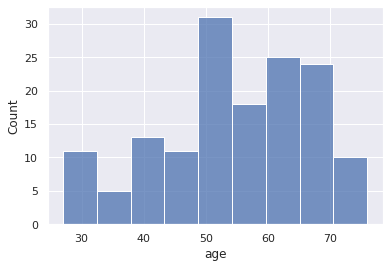

In [201]:
sns.histplot(data=df_treated, x="age")

In [197]:
df_treated = df_all[df_all["treated"] == 1]
df_distant = try_interactions(df_treated, features, "distant_relapse") 
df_local = try_interactions(df_treated, features, "local_relapse") 

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


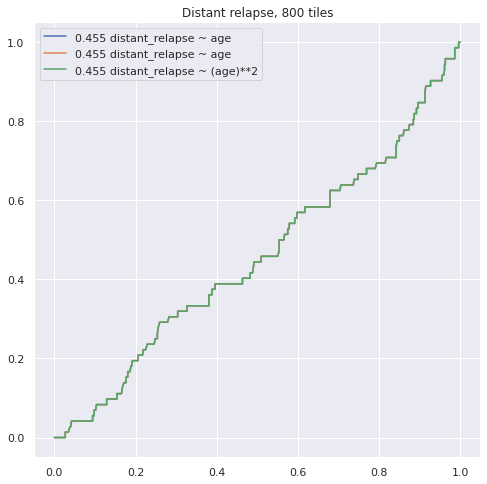

In [198]:
plt.figure(figsize=(8,8))
sns.set()
plt.title("Distant relapse, 800 tiles")
for n, row in df_distant.iloc[:3].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend()

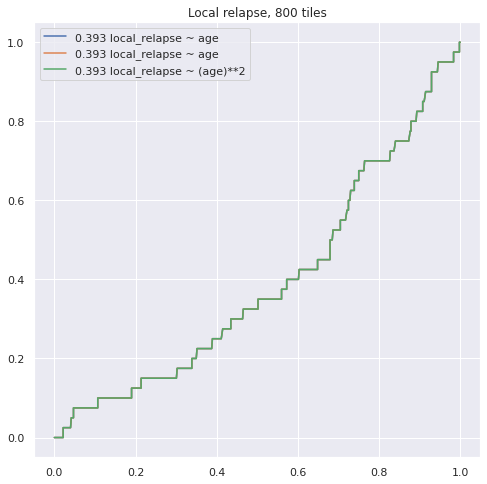

In [199]:
plt.figure(figsize=(8,8))
plt.title("Local relapse, 800 tiles")
for n, row in df_local.iloc[0:3].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend()

In [16]:
def logit_features(features, classes, df):
    df = df[features + classes].dropna()
    X = df[features].values
    y = df[classes].values
    return logit(y, X)
    

df = df_all1[df_all1["treated"] == 1]
true, pred = logit_features(['stroma_tils'], ['local_relapse'] , df_all)
tpr, fpr, thresholds = roc_curve(true, pred)
print(roc_auc_score(true, pred))
plt.plot(tpr, fpr)

NameError: name 'df_all1' is not defined

In [ ]:
df2

In [ ]:
df2

In [ ]:
sns.histplot(data=df_all, x="immune_cluster1")
plt.figure()
sns.histplot(data=df_all, x="immune_cluster2")
plt.figure()
sns.histplot(data=df_all, x="immune_cluster3")
plt.figure()
sns.histplot(data=df_all, x="immune_cluster4")

In [ ]:
from scipy.stats import ttest_ind
features = [
    "TILs helsnitt",
    "TILs TMA",
    "immune_cluster",
    "tumor_cluster",
    "n_immune",
    "n_tumor",
    "stroma_tils",
    "tumor_tils",
    "immune_area",
    "tumor_area"
]

df = df_all1[df_all1["treated"] == 1]
groups = [
    "local_relapse",
    "distant_relapse",
    "dead"
]

d = []
for f in features:
    for g in groups:
        a = df[df[g] == 1][f].dropna()
        b = df[df[g] == 0][f].dropna()
        r, p = ttest_ind(a ,b)
        d.append(
        {
            "feature" : f,
            "group" : g,
            "r" : r,
            "p" : p,
            "n" : (len(a), len(b))
        })
df_ttest = pd.DataFrame(d).sort_values("p")
df_ttest.iloc[:10]